In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, LongType, StructType, StructField, StringType, DoubleType, BooleanType, IntegerType
import pyspark.sql.functions as f
from pyspark.sql import Window
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('Crypto').getOrCreate()
SCHEMA = StructType([
    StructField("dt", LongType(), False),
    StructField("base", StringType(), False),
    StructField("quote", StringType(), False),
    StructField("exchange", StringType(), False),
    StructField("bidPrice", DoubleType(), False),
    StructField("bidQty", DoubleType(), False),
    StructField("askPrice", DoubleType(), False),
    StructField("askQty", DoubleType(), False),
])
df = spark.read.options(delimiter='\t', ).csv("../logs/logs7.tsv", header=False, schema=SCHEMA)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/21 13:19:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def get_id(x):
    d = {"binance": 1.0, "poloniex": 2.0, "gate": 3.0, "huobi": 4.0, "kraken": 5.0}
    return d[x]

func_id = f.udf(get_id, DoubleType())
df = df.withColumn("idExchange", func_id("exchange"))

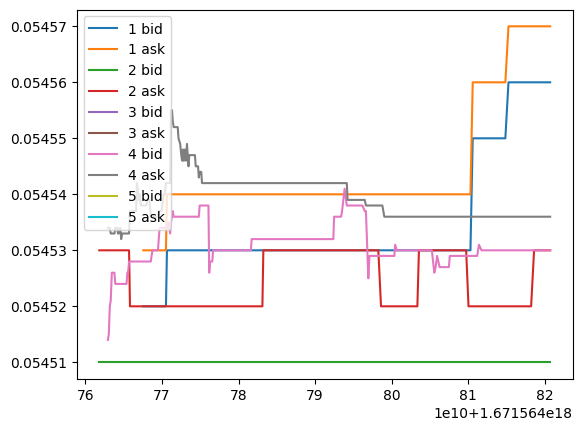

In [7]:
for e in range(1, 6):
    exch = df[(df["idExchange"] == float(e)) & (df["base"] == "TRX") & (df["quote"] == "USDT")].collect()
    bid = [e["bidPrice"] for e in exch]
    ask = [e["askPrice"] for e in exch]
    dt = [e["dt"] for e in exch]
    plt.plot(dt, bid, label=f"{e} bid")
    plt.plot(dt, ask, label=f"{e} ask")
    
plt.legend()
plt.show()

In [211]:
test = df.groupBy(['dt', "base", "quote"])\
         .agg(f.collect_list(f.struct("idExchange", "bidPrice", "bidQty", "askPrice", "askQty")).alias("data"))

In [212]:
def mult(rows):
    multed = []
    for row_bid in rows:
        for row_ask in rows:
            if row_bid["idExchange"] != row_ask["idExchange"]:
                multed.append([row_bid["idExchange"], row_ask["idExchange"], row_bid["bidPrice"], row_bid["bidQty"], row_ask["askPrice"], row_ask["askQty"]])
    return multed

In [213]:
func_mult = f.udf(mult, ArrayType(ArrayType(DoubleType())))

In [214]:
test = test.withColumn("multed", func_mult("data"))

In [215]:
def pyspark_len(x):
    return len(x)

func_len = f.udf(pyspark_len, IntegerType())

In [216]:
test = test.withColumn("len", func_len("multed"))

In [217]:
test = test[test["len"] > 0]

In [218]:
test = test.select(test["dt"], test["base"], test["quote"], f.explode("multed"))

In [219]:
test = test.select(test["dt"], test["base"], test["quote"], *[f.col("col")[e] for e in range(6)])

In [220]:
test = test.withColumnRenamed("col[0]", "bidExchange")\
           .withColumnRenamed("col[1]", "askExchange")\
           .withColumnRenamed("col[2]", "bidPrice")\
           .withColumnRenamed("col[3]", "bidQty")\
           .withColumnRenamed("col[4]", "askPrice")\
           .withColumnRenamed("col[5]", "askQty")

In [221]:
test = test.withColumn("Qty", f.least("bidQty", "askQty"))\
           .withColumn("revenue", (f.col("bidPrice") * 0.99 - f.col("askPrice")) * f.col("Qty"))

In [222]:
test3 = test.groupBy(["base", "quote", "bidExchange", "askExchange"]) \
    .agg(f.collect_list(f.struct("dt", "bidPrice", "askPrice", "Qty", "revenue")).alias("data"))

def calc_avg(x):
    return sum(x) / len(x)


def calc_len(x):
    return len(x) >= 1


def test(x):
    return len(x)


def find(rows):
    N = 10 ** 8
    if len(rows) == 1:
        return [N]
    arbitrages = []
    rows.sort(key=lambda x: x["dt"])
    old = rows[0]
    dur = 0
    for row in rows[1:]:
        if row["revenue"] > 0 and old["revenue"] > 0:
            dur += row["dt"] - old["dt"]
        elif row["revenue"] <= 0 and old["revenue"] > 0:
            arbitrages.append(dur + N)
            dur = 0
        old = row
    if row["revenue"] > 0:
        arbitrages.append(dur + N)
    return arbitrages


func = f.udf(find, ArrayType(LongType()))
func2 = f.udf(calc_avg, DoubleType())
func3 = f.udf(calc_len, BooleanType())
func4 = f.udf(test, IntegerType())

test3 = test3.withColumn("arbitrations", func("data")) \
    .withColumn("is_not_empty", func3("arbitrations")) \
    .withColumn("len", func4("arbitrations"))
test3 = test3[test3["is_not_empty"] == True].withColumn("avg_arb", func2("arbitrations"))

In [223]:
test3.sort("len", ascending=False).show()

+-----+-----+-----------+-----------+--------------------+-------------+------------+---+---------------+
| base|quote|bidExchange|askExchange|                data| arbitrations|is_not_empty|len|        avg_arb|
+-----+-----+-----------+-----------+--------------------+-------------+------------+---+---------------+
| ETHW|  ETH|        5.0|        2.0|[{167156476661241...|[54304086120]|        true|  1| 5.430408612E10|
|  FTT| USDT|        2.0|        4.0|[{167156476456717...|[56226577159]|        true|  1|5.6226577159E10|
|  HFT| USDT|        2.0|        1.0|[{167156479318501...|  [353923663]|        true|  1|   3.53923663E8|
|  TON| USDT|        2.0|        4.0|[{167156476424691...|[57612600817]|        true|  1|5.7612600817E10|
| ETHF| USDT|        2.0|        4.0|[{167156480192413...|[19497316514]|        true|  1|1.9497316514E10|
|  FTM|  BTC|        2.0|        1.0|[{167156479433258...|[26461160406]|        true|  1|2.6461160406E10|
|LAZIO| USDT|        1.0|        2.0|[{1671564